## Importing the Libraries and Loading the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

## 1.EDA

In [5]:
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None


In [7]:
print(products.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None


In [9]:
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB
None


## Merging Data

In [11]:
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

## Visualizations

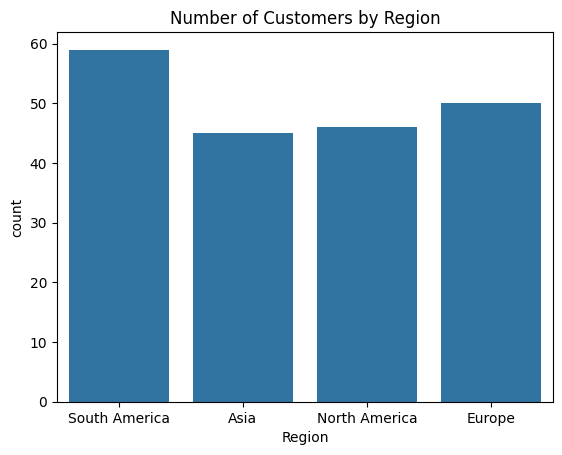

In [13]:
sns.countplot(x='Region', data=customers)
plt.title('Number of Customers by Region')
plt.show()

## Top Selling Products

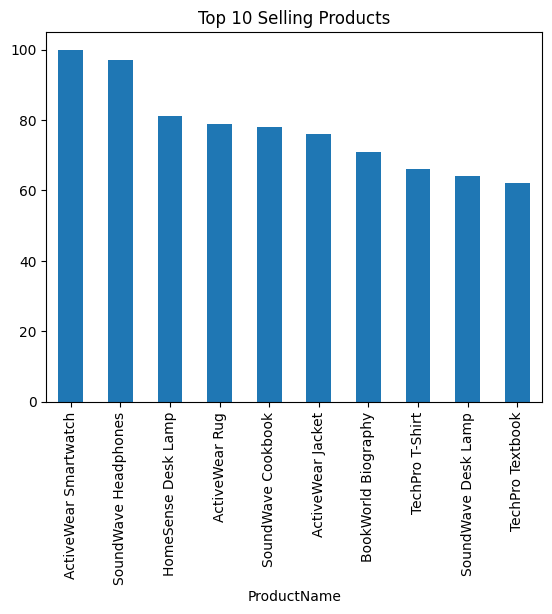

In [15]:
top_products = merged_data.groupby('ProductName')['Quantity'].sum().nlargest(10)
top_products.plot(kind='bar')
plt.title('Top 10 Selling Products')
plt.show()

## 2.Lookalike Model

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
print(merged_data.columns)

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category', 'Price_y'],
      dtype='object')


## Preprocess Data

In [35]:
# Feature engineering
customer_profiles = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price_x': 'mean',
    'Price_y': 'mean'
}).reset_index()

In [37]:
# Normalize data
scaler = StandardScaler()
features = scaler.fit_transform(customer_profiles.iloc[:, 1:])

C:\Users\achyu\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\achyu\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\achyu\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\achyu\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

## Computing Similarity

In [39]:
similarity_matrix = cosine_similarity(features)

## Top 3 lookalikes

In [43]:
lookalike_dict = {}
for i, customer_id in enumerate(customer_profiles['CustomerID']):
    similar_indices = similarity_matrix[i].argsort()[-4:-1][::-1]  # Exclude self
    similar_customers = [(customer_profiles.iloc[idx]['CustomerID'], similarity_matrix[i, idx]) for idx in similar_indices]
    lookalike_dict[customer_id] = similar_customers

# Convert to CSV
lookalike_df = pd.DataFrame([
    {'CustomerID': key, 'Lookalikes': value} for key, value in lookalike_dict.items()
])
lookalike_df.to_csv('Lookalike.csv', index=False)

## 3. Clustering

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [49]:
# Select features
clustering_data = customer_profiles.iloc[:, 1:]

In [59]:
# Fit KMeans
kmeans = KMeans(n_clusters=5, random_state=42)

In [63]:
# Evaluate
db_index = davies_bouldin_score(clustering_data)
print('DB Index:', db_index)

TypeError: davies_bouldin_score() missing 1 required positional argument: 'labels'

## Visualizations

C:\Users\achyu\AppData\Local\Temp\ipykernel_18608\1064589779.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=clustering_data['TotalValue'], y=clustering_data['Quantity'],palette='viridis')


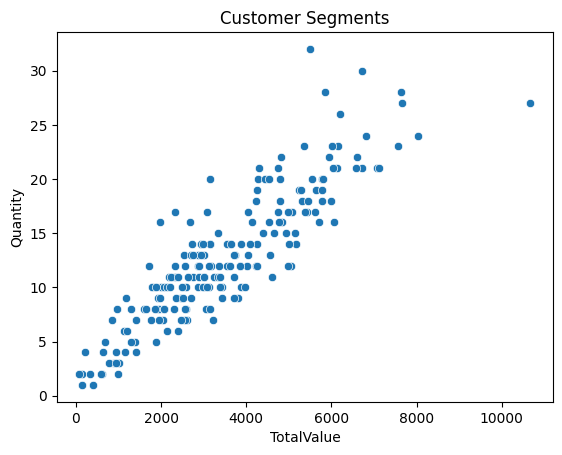

In [67]:
sns.scatterplot(x=clustering_data['TotalValue'], y=clustering_data['Quantity'],palette='viridis')
plt.title('Customer Segments')
plt.show()